In [ ]:
import warnings
warnings.filterwarnings("ignore")
import logging
logging.disable(logging.CRITICAL)
import os 
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly_resampler import FigureResampler, FigureWidgetResampler

import importlib
from utils.afrr_preprocessing import preprocess_afrr_data
from lr_forecaster import run_lr_pipeline
#from gp_forecaster import run_gp_pipeline
from xgb_forecaster import run_xgb_pipeline

from utils.forecast_utils import get_forecast_params
from darts.timeseries import concatenate

%load_ext autoreload
%autoreload 2
%matplotlib inline

ImportError: cannot import name '_LikelihoodMixin' from 'darts.models.forecasting.regression_model' (/home/alqua/anaconda3/envs/opt_env/lib/python3.12/site-packages/darts/models/forecasting/regression_model.py)

In [11]:
data_path = "../data/afrr_price.parquet"
train_start = "2024-10-01 22:00:00"
test_start = "2025-01-09 22:00:00"
test_end = "2025-03-20 22:00:00"
target_col = "aFRR_DownCapPriceEUR"

In [12]:
forecast_params = get_forecast_params()
output_chunk_length = forecast_params['output_chunk_length']
forecast_horizon = forecast_params['forecast_horizon']
stride = forecast_params['stride']
quantiles = forecast_params['quantiles']

lr_models, lr_results = run_lr_pipeline(
    data_path=data_path,
    target_col=target_col,
    hyper_params_path= "../data/results/lr_aFRR_DownCapPriceEUR_hp_results.json",
    train_start=train_start,
    test_start=test_start,
    test_end=test_end,
    output_chunk_length=output_chunk_length,
    forecast_horizon=forecast_horizon,
    stride=stride)

#lr_results.to_parquet("lr_model_forecast.par")


----------------------------------------
EMBEDDING SUMMARY:
Embedding dimension	:  120
Trajectory dimensions	: (120, 3672)
Complete dimension	: (120, 3672)
Missing dimension     	: (120, 0)
----------------------------------------
DECOMPOSITION SUMMARY:
Rank of trajectory		: 120
Dimension of projection space	: 109
Characteristic of projection	: 0.9997


historical forecasts:   0%|          | 0/1 [00:00<?, ?it/s]

### Gaussian process Models 

In [ ]:
forecast_params = get_forecast_params()
output_chunk_length = forecast_params['output_chunk_length']
forecast_horizon = forecast_params['forecast_horizon']
stride = forecast_params['stride']
quantiles = forecast_params['quantiles']

gp_model, gp_results = run_gp_pipeline(
    data_path=data_path,
    hyper_params_path="../data/results/gp_hp_results.json",
    train_start=train_start,
    test_start=test_start,
    test_end=test_end,
    output_chunk_length=output_chunk_length,
    forecast_horizon=forecast_horizon,
    stride=stride,
    quantiles=quantiles
)

#gp_results.to_parquet("gp_model_forecast.par")

----------------------------------------
EMBEDDING SUMMARY:
Embedding dimension	:  120
Trajectory dimensions	: (120, 3672)
Complete dimension	: (120, 3672)
Missing dimension     	: (120, 0)
----------------------------------------
DECOMPOSITION SUMMARY:
Rank of trajectory		: 120
Dimension of projection space	: 114
Characteristic of projection	: 0.9997


historical forecasts:   0%|          | 0/1 [00:00<?, ?it/s]

### XgBoost Model

In [ ]:
forecast_params = get_forecast_params()
output_chunk_length = forecast_params['output_chunk_length']
forecast_horizon = forecast_params['forecast_horizon']
stride = forecast_params['stride']

xgb_model, xgb_results = run_xgb_pipeline(
    data_path=data_path,
    hyper_params_path="../data/results/xgb_hp_results.json",
    train_start=train_start,
    test_start=test_start,
    test_end=test_end,
    output_chunk_length=output_chunk_length,
    forecast_horizon=forecast_horizon,
    stride=stride)

#xgb_results.to_parquet("xgboost_model_forecast.par")

----------------------------------------
EMBEDDING SUMMARY:
Embedding dimension	:  120
Trajectory dimensions	: (120, 3672)
Complete dimension	: (120, 3672)
Missing dimension     	: (120, 0)
----------------------------------------
DECOMPOSITION SUMMARY:
Rank of trajectory		: 120
Dimension of projection space	: 114
Characteristic of projection	: 0.9997


historical forecasts:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
xgb_results

component,xgb_afrr_up_cap_price
time_utc,
2024-10-03 23:00:00,86.518318
2024-10-04 00:00:00,83.821045
2024-10-04 01:00:00,85.437958
2024-10-04 02:00:00,93.367157
2024-10-04 03:00:00,103.294868
...,...
2025-03-09 18:00:00,42.675049
2025-03-09 19:00:00,26.741364
2025-03-09 20:00:00,29.468845


### Original Model

In [ ]:
(afrr_pr_ts_scl_train, 
afrr_pr_ts_scl_test, 
afrr_pr_ts_orig_train, 
afrr_pr_ts_orig_test, 
exog_ts_scl_train, 
exog_ts_scl_test,
afrr_pr_scaler
) = preprocess_afrr_data(data_path, train_start, test_start, test_end)

----------------------------------------
EMBEDDING SUMMARY:
Embedding dimension	:  120
Trajectory dimensions	: (120, 3672)
Complete dimension	: (120, 3672)
Missing dimension     	: (120, 0)
----------------------------------------
DECOMPOSITION SUMMARY:
Rank of trajectory		: 120
Dimension of projection space	: 114
Characteristic of projection	: 0.9997


In [ ]:
afrr_pr_ts_orig = concatenate([afrr_pr_ts_orig_train, afrr_pr_ts_orig_test], axis=0)
afrr_pr_ts_orig = afrr_pr_ts_orig.with_columns_renamed(['aFRR_UpCapPriceEUR'], col_names_new=["afrr_up_cap_price"])
result_df = lr_results.join([xgb_results,gp_results, afrr_pr_ts_orig.pd_dataframe()])

In [ ]:
result_df.columns

Index(['lr_afrr_up_cap_price', 'xgb_afrr_up_cap_price',
       'gp_afrr_up_cap_price_0.1', 'gp_afrr_up_cap_price_0.5',
       'gp_afrr_up_cap_price_0.9', 'afrr_up_cap_price'],
      dtype='object')

In [ ]:
import plotly.graph_objects as go
from plotly_resampler import FigureResampler, FigureWidgetResampler
 
 
fig = FigureWidgetResampler(go.Figure())
fig.update_layout(margin=dict(l=10, r=10, t=10, b=10))
fig.add_trace(go.Scattergl(name=r'AFRR Up Cap Price', showlegend=True), hf_x=result_df.index, hf_y=result_df['afrr_up_cap_price'])
fig.add_trace(go.Scattergl(name=r'AFRR Up Cap Price Linear Model', showlegend=True), hf_x=result_df.index, hf_y=result_df['lr_afrr_up_cap_price'])
fig.add_trace(go.Scattergl(name=r'AFRR Up Cap Price Gaussian Process', showlegend=True), hf_x=result_df.index, hf_y=result_df['gp_afrr_up_cap_price_0.5'])
fig.add_trace(go.Scattergl(name=r'AFRR Up Cap Price XGB Mean', showlegend=True), hf_x=result_df.index, hf_y=result_df['xgb_afrr_up_cap_price'])
fig.update_layout(height=400, template="plotly_dark")
display(fig)

FigureWidgetResampler({
    'data': [{'name': ('<b style="color:sandybrown">[R' ... ' style="color:#fc9944">~3h</i>'),
              'showlegend': True,
              'type': 'scattergl',
              'uid': 'fd99388c-adf1-42d5-8d11-3c2ef51986ef',
              'x': array([datetime.datetime(2024, 10, 15, 23, 0),
                          datetime.datetime(2024, 10, 16, 2, 0),
                          datetime.datetime(2024, 10, 16, 5, 0), ...,
                          datetime.datetime(2025, 3, 9, 17, 0),
                          datetime.datetime(2025, 3, 9, 19, 0),
                          datetime.datetime(2025, 3, 9, 22, 0)], dtype=object),
              'y': array([52.73, 52.  , 67.01, ..., 68.51, 44.64, 42.15])},
             {'name': ('<b style="color:sandybrown">[R' ... ' style="color:#fc9944">~3h</i>'),
              'showlegend': True,
              'type': 'scattergl',
              'uid': 'd601c865-0570-4174-9f9c-67eb4610c183',
              'x': array([datetime.dateti

In [ ]:
result_df = result_df[['lr_afrr_up_cap_price', 'xgb_afrr_up_cap_price','gp_afrr_up_cap_price_0.5','afrr_up_cap_price']]

In [7]:
result_df = pd.read_parquet('/home/alqua/git/afrr-price-forecast-engine/data/results/afrr_price_forecast_UP.parquet')

In [8]:
import cvxpy as cp
import numpy as np

# 1. Clean data
y_true = result_df['afrr_up_cap_price'].values
y_pred = result_df[['lr_afrr_up_cap_price', 'xgb_afrr_up_cap_price', 'gp_afrr_up_cap_price_0.5']].values

y_true = (y_true - np.mean(y_true)) / np.std(y_true)
y_pred = (y_pred - np.mean(y_pred, axis=0)) / np.std(y_pred, axis=0)
weights = cp.Variable(3)
constraints = [cp.sum(weights) == 1, weights >= 0]
objective = cp.Minimize(cp.sum_squares(y_true - y_pred @ weights))
problem = cp.Problem(objective, constraints)

try:
    problem.solve()
except:
    print('failed')

# 5. Output
if 'optimal' in problem.status:
    optimal_weights = weights.value
    print("Optimal weights:", optimal_weights)
else:
    print("Solver failed. Status:", problem.status)

Optimal weights: [0.45426964 0.39412718 0.15160318]


In [9]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error

result_df['opt_afrr_up_cap_price'] = (
    optimal_weights[0] * result_df['lr_afrr_up_cap_price'] + 
    optimal_weights[1] * result_df['xgb_afrr_up_cap_price'] + 
    optimal_weights[2] * result_df['gp_afrr_up_cap_price_0.5']
)

models = [
    'lr_afrr_up_cap_price',
    'xgb_afrr_up_cap_price',
    'gp_afrr_up_cap_price_0.5',
    'opt_afrr_up_cap_price'
]

rmse_results = {}
y_true = result_df['afrr_up_cap_price']

for model in models:
    rmse = np.sqrt(mean_squared_error(y_true, result_df[model]))
    rmse_results[model] = rmse

print("Model RMSE Comparison:")
for model, rmse in sorted(rmse_results.items(), key=lambda x: x[1]):
    print(f"- {model:25s}: {rmse:.4f}")

best_single_rmse = max(rmse_results.values()) - rmse_results['opt_afrr_up_cap_price']
print(f"\nOptimized forecast improves by {best_single_rmse:.4f} RMSE over best single model")

Model RMSE Comparison:
- opt_afrr_up_cap_price    : 23.9485
- lr_afrr_up_cap_price     : 25.3498
- xgb_afrr_up_cap_price    : 27.7732
- gp_afrr_up_cap_price_0.5 : 27.7732

Optimized forecast improves by 3.8247 RMSE over best single model


In [10]:
result_df['resid'] = (result_df['opt_afrr_up_cap_price'] - result_df['afrr_up_cap_price'])

In [11]:
from statsmodels.tsa.ar_model import AutoReg

# Fit AR model to residuals (choose optimal lag `p` via AIC)
ar_model = AutoReg(result_df['resid'].dropna(), lags=5)  # Start with lags=1, test higher
ar_results = ar_model.fit()
print(ar_results.summary())

# Get AR-corrected residuals (actual residuals - AR predictions)
result_df['ar_corrected_resid'] = ar_results.resid

                            AutoReg Model Results                             
Dep. Variable:                  resid   No. Observations:                 3431
Model:                     AutoReg(5)   Log Likelihood              -13770.015
Method:               Conditional MLE   S.D. of innovations             13.468
Date:                Wed, 16 Apr 2025   AIC                          27554.029
Time:                        09:47:05   BIC                          27597.003
Sample:                             5   HQIC                         27569.383
                                 3431                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4505      0.232      1.940      0.052      -0.005       0.906
resid.L1       0.8596      0.017     50.320      0.000       0.826       0.893
resid.L2      -0.0863      0.022     -3.836      0.0

<Figure size 1000x400 with 0 Axes>

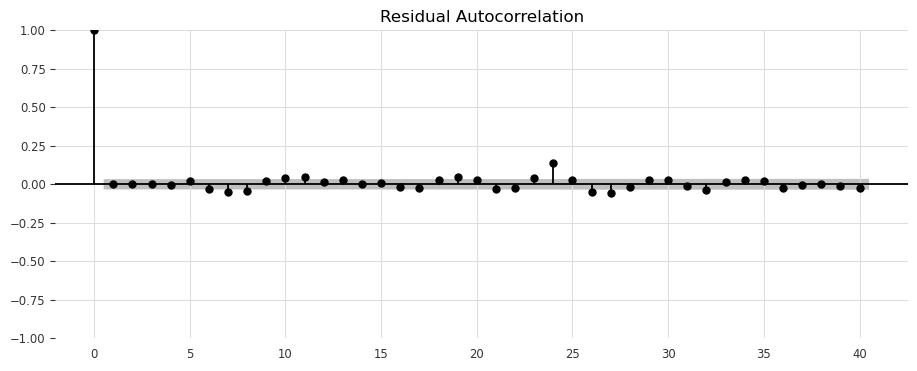

In [12]:
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plot_acf(result_df['ar_corrected_resid'].dropna(), lags=40, alpha=0.05)
plt.title('Residual Autocorrelation')
plt.show()

In [13]:
from arch import arch_model

# Fit GARCH(1,1) to AR-corrected residuals
garch_model = arch_model(
    result_df['ar_corrected_resid'].dropna(), 
    vol='Garch',  # Use 'EGarch' for asymmetric effects
    p=1, q=1      # GARCH(1,1)
)
garch_results = garch_model.fit(update_freq=5)
print(garch_results.summary())

# Get volatility-adjusted residuals (standardized residuals)
result_df['garch_volatility'] = garch_results.conditional_volatility
result_df['std_resid'] = result_df['ar_corrected_resid'] / result_df['garch_volatility']

Iteration:      5,   Func. Count:     34,   Neg. LLF: 13659.65725762569
Iteration:     10,   Func. Count:     63,   Neg. LLF: 13659.067645027733
Iteration:     15,   Func. Count:     88,   Neg. LLF: 13658.710883619757
Optimization terminated successfully    (Exit mode 0)
            Current function value: 13658.710881059782
            Iterations: 17
            Function evaluations: 97
            Gradient evaluations: 17
                     Constant Mean - GARCH Model Results                      
Dep. Variable:     ar_corrected_resid   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -13658.7
Distribution:                  Normal   AIC:                           27325.4
Method:            Maximum Likelihood   BIC:                           27350.0
                                        No. Observations:                 3426
Date:              

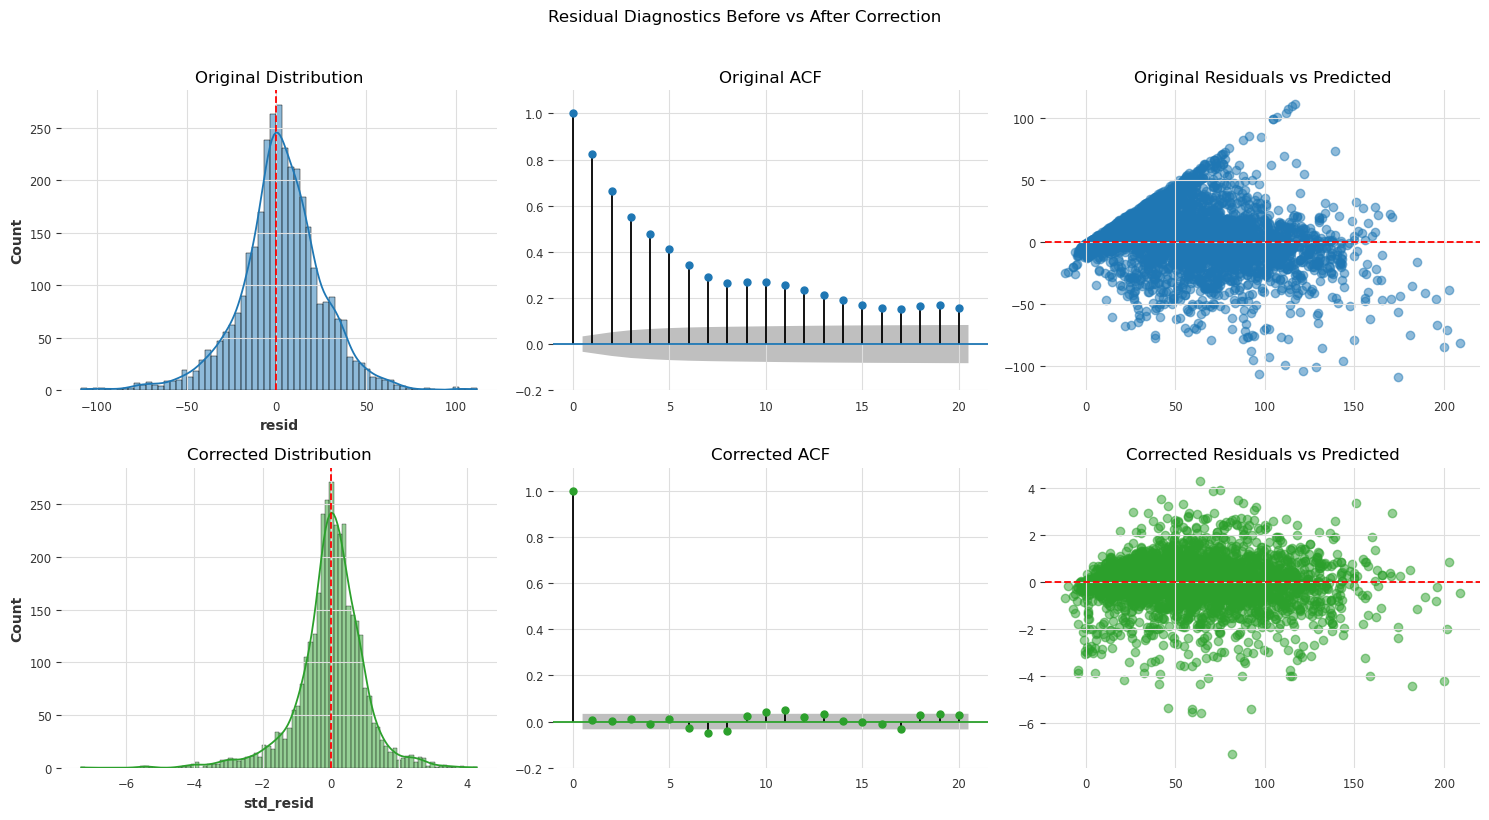

In [14]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
import seaborn as sns

# Set up the figure
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
plt.suptitle('Residual Diagnostics Before vs After Correction', y=1.02)

# --- Row 1: Original Residuals ---
# 1. Distribution
sns.histplot(result_df['resid'].dropna(), kde=True, ax=axes[0,0], color='#1f77b4')
axes[0,0].axvline(0, color='r', linestyle='--')
axes[0,0].set_title('Original Distribution')

# 2. Autocorrelation
plot_acf(result_df['resid'].dropna(), lags=20, alpha=0.05, ax=axes[0,1], color='#1f77b4')
axes[0,1].set_title('Original ACF')
axes[0,1].set_ylim(-0.2, 1.1)

# 3. Heteroskedasticity
axes[0,2].scatter(result_df['opt_afrr_up_cap_price'], result_df['resid'], alpha=0.5, color='#1f77b4')
axes[0,2].axhline(0, color='r', linestyle='--')
axes[0,2].set_title('Original Residuals vs Predicted')

# --- Row 2: Corrected Residuals ---
# 4. Corrected Distribution
sns.histplot(result_df['std_resid'].dropna(), kde=True, ax=axes[1,0], color='#2ca02c')
axes[1,0].axvline(0, color='r', linestyle='--')
axes[1,0].set_title('Corrected Distribution')

# 5. Corrected ACF
plot_acf(result_df['std_resid'].dropna(), lags=20, alpha=0.05, ax=axes[1,1], color='#2ca02c')
axes[1,1].set_title('Corrected ACF')
axes[1,1].set_ylim(-0.2, 1.1)

# 6. Corrected Heteroskedasticity
axes[1,2].scatter(result_df['opt_afrr_up_cap_price'], result_df['std_resid'], alpha=0.5, color='#2ca02c')
axes[1,2].axhline(0, color='r', linestyle='--')
axes[1,2].set_title('Corrected Residuals vs Predicted')

# Adjust layout
plt.tight_layout()
plt.show()